# Butterfly Image Classification

In this notebook, I built a CNN model to classify images of butterflies. The data I used has 6499 images for training and 2786 images for testing, with 75 different butterfly classes.

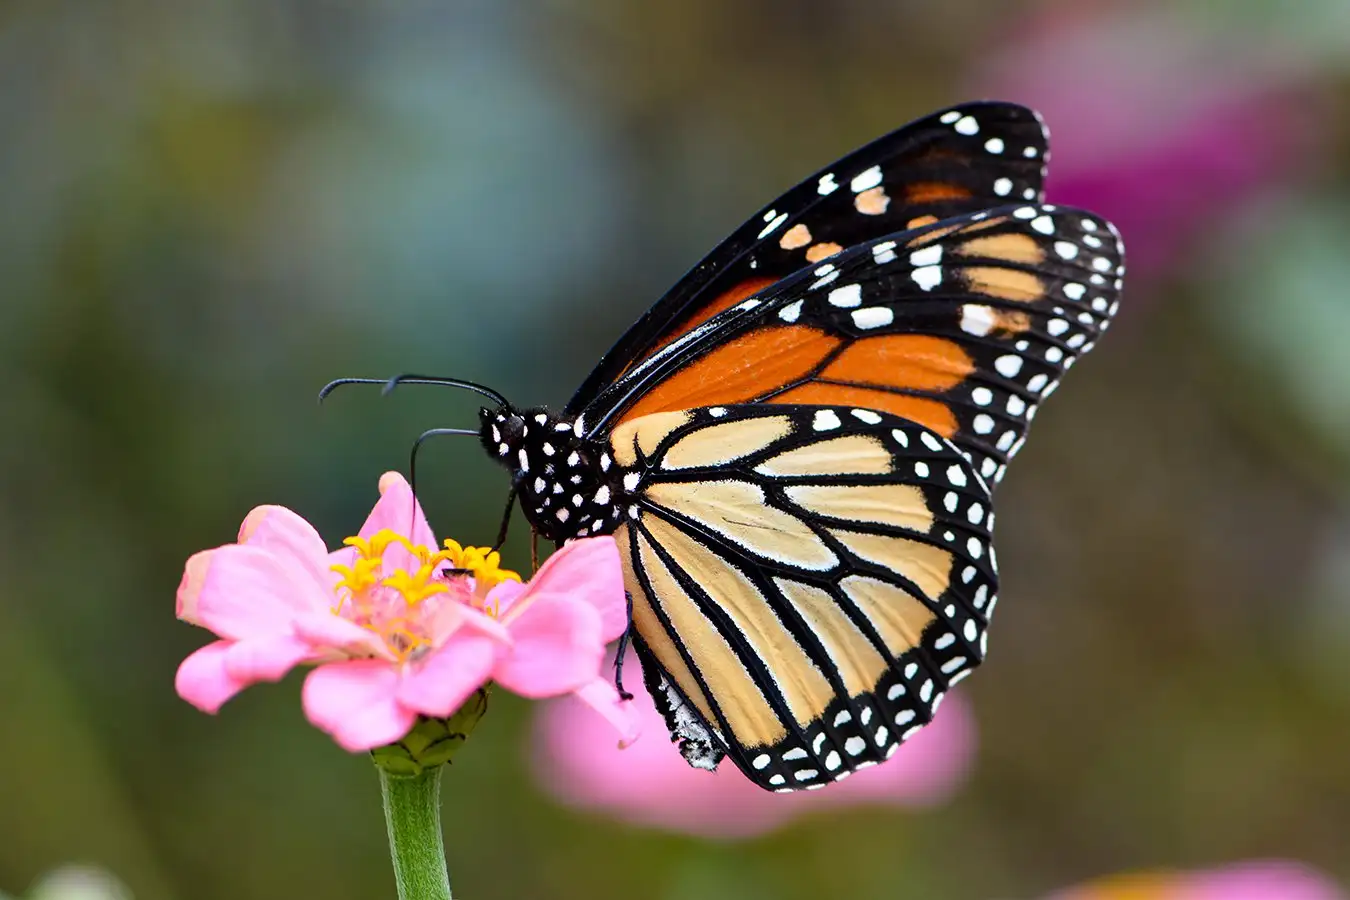

Image: https://www.newscientist.com/article/2378790-monarch-butterflies-big-white-spots-help-them-fly-better/

Dataset: https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification/data

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from zipfile import ZipFile

In [2]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Unzip file
with ZipFile('butterflies.zip', 'r') as f:
    f.extractall()

In [16]:
# Load data
train_df = pd.read_csv('Training_set.csv')
test_df = pd.read_csv('Testing_set.csv')

train_df.describe()

,filename,label
count,6499,6499
unique,6499,75
top,Image_1.jpg,MOURNING CLOAK
freq,1,131


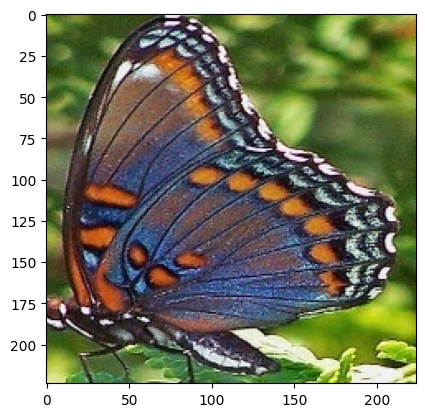

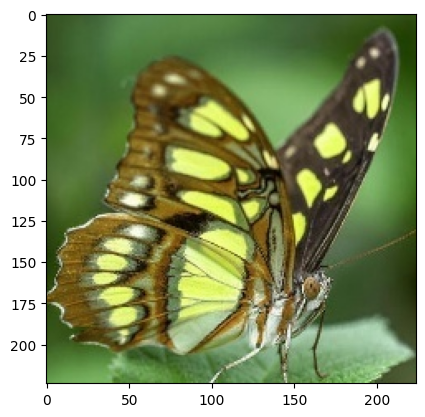

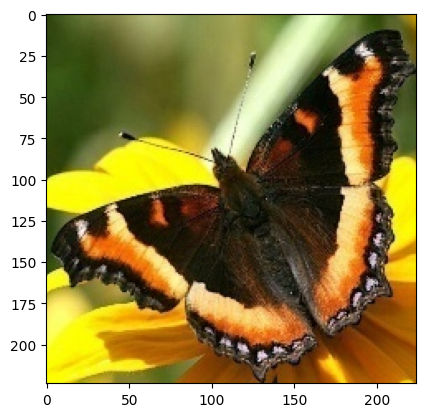

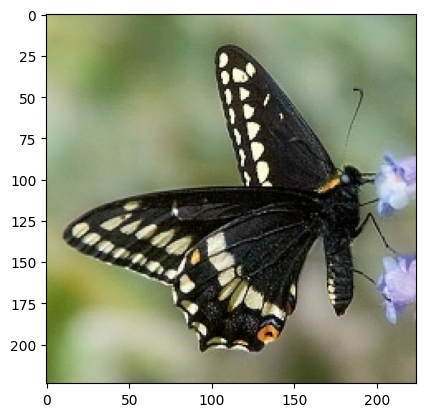

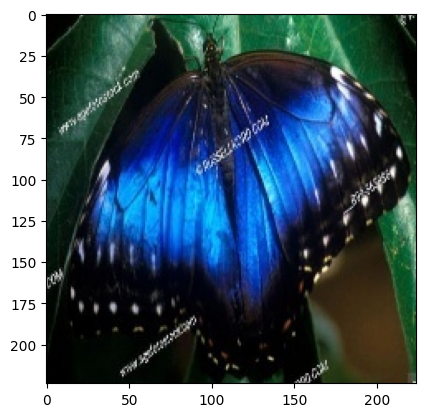

In [18]:
# Image examples
arr = np.random.randint(0, len(train_df), size = 5)
for i in arr:
    plt.imshow(PIL.Image.open('train/' + train_df['filename'][i]))
    plt.show()

In [5]:
# Define parameters
batch_size = 32
img_height = 180
img_width = 180

# Define data generators
train_gen = ImageDataGenerator(rescale = 1.0/255, validation_split = 0.2)
test_gen = ImageDataGenerator(rescale = 1.0/255)

train_data = train_gen.flow_from_dataframe(
    train_df,
    directory = 'train/',
    seed = 42,
    x_col = 'filename',
    y_col = 'label',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training'
)

validation_data = train_gen.flow_from_dataframe(
    train_df,
    directory = 'train/',
    seed = 42,
    x_col = 'filename',
    y_col = 'label',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'validation'
)

test_data = test_gen.flow_from_dataframe(
    test_df,
    directory = 'test/',
    seed = 42,
    x_col = 'filename',
    y_col = None,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = None,
    shuffle = False
)

Found 5200 validated image filenames belonging to 75 classes.
Found 1299 validated image filenames belonging to 75 classes.
Found 2786 validated image filenames.


### Build Model

In [6]:
# Create model
num_classes = 75

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), padding = 'same', activation = 'relu', input_shape = (img_height, img_width, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), padding = 'same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), padding = 'same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), padding = 'same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation = 'softmax')
])

# Display summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 180, 180, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 90, 90, 64)        256       
 chNormalization)                                                
                                                        

In [7]:
# Compile and train model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_data,
    steps_per_epoch = train_data.samples // train_data.batch_size,
    validation_data = validation_data,
    validation_steps = validation_data.samples // validation_data.batch_size,
    epochs = 15,
    callbacks = [early_stopping]
)

Epoch 1/15
162/162 [==============================] - 443s 3s/step - loss: 4.0918 - accuracy: 0.1055 - val_loss: 7.4510 - val_accuracy: 0.0172
Epoch 2/15
162/162 [==============================] - 463s 3s/step - loss: 2.8447 - accuracy: 0.2717 - val_loss: 5.6485 - val_accuracy: 0.0312
Epoch 3/15
162/162 [==============================] - 435s 3s/step - loss: 2.2980 - accuracy: 0.3808 - val_loss: 2.5442 - val_accuracy: 0.3242
Epoch 4/15
162/162 [==============================] - 423s 3s/step - loss: 1.8425 - accuracy: 0.4932 - val_loss: 1.8911 - val_accuracy: 0.4859
Epoch 5/15
162/162 [==============================] - 439s 3s/step - loss: 1.4849 - accuracy: 0.5799 - val_loss: 1.8260 - val_accuracy: 0.5094
Epoch 6/15
162/162 [==============================] - 435s 3s/step - loss: 1.2941 - accuracy: 0.6254 - val_loss: 1.3673 - val_accuracy: 0.6320
Epoch 7/15
162/162 [==============================] - 433s 3s/step - loss: 1.0008 - accuracy: 0.7088 - val_loss: 1.1676 - val_accuracy: 0.6695

### Evaluation

In [8]:
# Evaluation metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

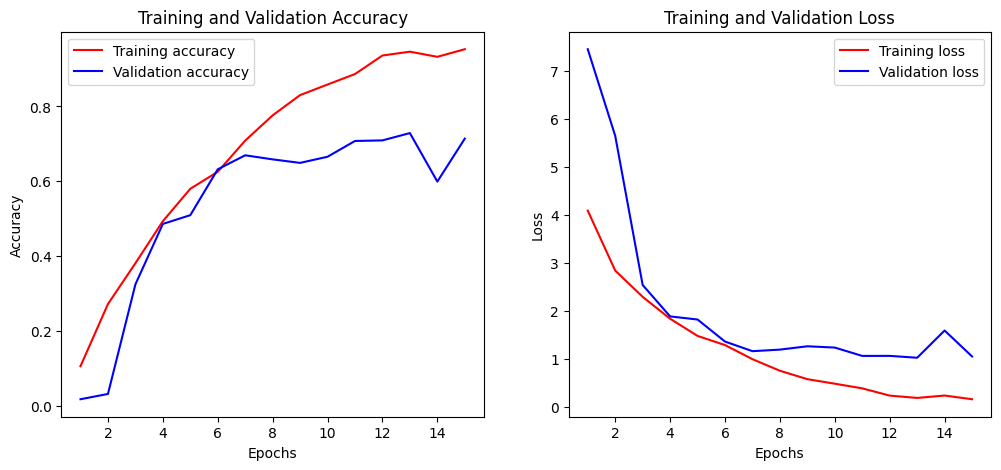

In [11]:
# Plot training and validation accuracies
plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
# Make predictions
predictions = model.predict(test_data)

predicted_classes = predictions.argmax(axis = 1)
labels = list(train_data.class_indices.keys())
predicted_labels = [labels[i] for i in predicted_classes]

test_df['label'] = predicted_labels

88/88 [==============================] - 64s 723ms/step


In [13]:
# Predicted labels
test_df.head(20)

,filename,label
0,Image_1.jpg,PINE WHITE
1,Image_2.jpg,CRIMSON PATCH
2,Image_3.jpg,ADONIS
3,Image_4.jpg,IPHICLUS SISTER
4,Image_5.jpg,MILBERTS TORTOISESHELL
5,Image_6.jpg,SOUTHERN DOGFACE
6,Image_7.jpg,PAPER KITE
7,Image_8.jpg,BLUE SPOTTED CROW
8,Image_9.jpg,RED CRACKER
9,Image_10.jpg,ZEBRA LONG WING


In [14]:
# Results
print(f'Accuracy after 15 epochs: {acc[-1]}')
print(f'Validation accuracy after 15 epochs: {val_acc[-1]}')
print(f'Loss after 15 epochs: {loss[-1]}')
print(f'Validation loss after 15 epochs: {val_loss[-1]}')

Accuracy after 15 epochs: 0.9531733989715576
Validation accuracy after 15 epochs: 0.714062511920929
Loss after 15 epochs: 0.16761527955532074
Validation loss after 15 epochs: 1.0575107336044312
